<a href="https://colab.research.google.com/github/evan-cao-wb/Deep-Learning/blob/master/Anti_Asian_Hate_in_Social_Media_during_the_COVID_19_Crisis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount(r"/content/drive/")

Mounted at /content/drive/


In [2]:
!pip install transformers
!python -m spacy download en_vectors_web_lg

     |████████████████████████████████| 890kB 5.9MB/s 
     |████████████████████████████████| 3.0MB 22.9MB/s 
     |████████████████████████████████| 1.1MB 56.6MB/s 
     |████████████████████████████████| 890kB 50.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=2cf23b8b5c4c905083c8a66f42bab5b1976c2de1418221babb036006a98c5394
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 661.8MB 1.1MB/s 
  Created wheel for en-vectors-web-lg: filename=en_vectors_web_lg-2.1.0-cp36-none-any.whl size=663461749 sha256=2abc8aa1f1416c0533c00578f0b2e55928d331bddd89ea546514ef33c54f266b
  Stored in directory: /tmp/pip-ephem-wheel-cache-imq56_wl/wheels/ce/3e/83/59647d0b4584003cce18fb68ecda2866e7c7b2722c3ecaddaf
Successfully built en-vectors-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('

# Anti-Asian Hate in Social Media during the COVID-19 Crisis
*Author: Evan Cao*

Few shot learning method have gotten an unprecedented achievement for applying deep learning models on a small dataset in Computer Vision industry. In this notebook, I would like to reproduce the same methods but apply them on the small tabular&text dataset.   

To accomplished this goal, I break down whole process into the following steps:
- Extracted a small number of data to form support set. The support set would assist us to make predictions. Then, we splited the rest of data into the training set and the testing set.
- Through incorporating different/unified labeled text to a pair of texts from the training set, we generated a large amount of datasets and labeled each pair by checking if each pair of texts shared the same labels.
- Pre-trained the feature extractor on the above dataset to get discriminative feature vectors by building a binary classification task
- Combined this feature extractor with support sets to make a prediction by comparing cosine/absoluate distances on testing dataset.
- Summarized the experimental results.

In [210]:
import os,gc,time,re
import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import roc_auc_score,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn

import torchtext
from torchtext import data

import nltk
import string
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud
import spacy
import transformers,tokenizers
from transformers import BertConfig,BertTokenizer,BertPreTrainedModel

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
nltk.download('punkt')
nlp = spacy.load("en_vectors_web_lg")
nlp.add_pipe(nlp.create_pipe('sentencizer'))
model_path = r"/content/drive/My Drive/roberta_model/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Bert_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

TOKENIZER = tokenizers.ByteLevelBPETokenizer(
    vocab_file=f"{model_path}/vocab.json", 
    merges_file=f"{model_path}/merges.txt", 
    lowercase=True,
    add_prefix_space=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Process and Generate Dataset

The anti-asian dataset was collected by Georgia Institute of Technology and aimed at how to mitigate the hate Ais spread

In [8]:
data_path = r"/content/drive/My Drive/Graph_data/"
annt_data = pd.read_csv(os.path.join(data_path,'annotated',"annotations.csv"))
annt_data = annt_data.drop_duplicates().reset_index(drop=True)
annt_data = annt_data.drop(index=[1457,1565, 1572,1455,1473,76,239,196 ]).reset_index(drop=True)
annt_data['Encode_Label'] = annt_data['Label'].map({"Hate":0,"Counterhate":1,"Neutral":2,"Non-Asian Aggression":3})

In [51]:
annt_data.head()

,Text,Label,Encode_Label
0,@China_Amb_India Fucking piece of shit your wh...,Hate,0
1,I’m not being funny but #Coronavirus in.... ...,Neutral,2
2,Got on the Victoria Line today to seven sister...,Hate,0
3,It's appalling that the media &amp; libtards b...,Hate,0
4,Dude fuck the Chinese man fuck em and if you t...,Hate,0


In [52]:
annt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2213 entries, 0 to 2212
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Text          2213 non-null   object
 1   Label         2213 non-null   object
 2   Encode_Label  2213 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 52.0+ KB


In [10]:
#@title
def remove_leading_usernames(tweet):
    """
        Remove all user handles at the beginning of the tweet.

        Parameters
        -----------------
        tweet : str, a valid string representation of the tweet text
    """
    regex_str = '^[\s.]*@[A-Za-z0-9_]+\s+'

    original = tweet
    change = re.sub(regex_str, '', original)

    while original != change:
      original = change
      change = re.sub(regex_str, '', original)

    return change
def process_tweet(tweet):
    """
        Preprocess tweet. Remove URLs, leading user handles, retweet indicators, emojis,
        and unnecessary white space, and remove the pound sign from hashtags. Return preprocessed
        tweet in lowercase.

        Parameters
        -----------------
        tweet : str, a valid string representation of the tweet text
    """
    #Remove @username
    tweet = remove_leading_usernames(tweet)
    #Remove www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))\s+','',tweet)
    tweet = re.sub('\s+((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    #Remove RTs
    tweet = re.sub('^RT @[A-Za-z0-9_]+: ', '', tweet)
    tweet = re.sub(r'(@[a-z0-9A-Z]+)\w+','',tweet.lower())
    # Incorrect apostraphe
    tweet = re.sub(r"’", "'", tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    #tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Replace ampersands
    tweet = re.sub(r' &amp; ', ' and ', tweet)
    tweet = re.sub(r'&amp;', '&', tweet)
    #Remove emojis
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    #trim
    tweet = tweet.strip('\'"')

    return tweet.lower().strip()

In [11]:
hate_support_set = annt_data[annt_data['Label']=="Hate"].sample(10)
counterhate_support_set = annt_data[annt_data['Label']=="Counterhate"].sample(10)
neutral_support_set = annt_data[annt_data['Label']=="Neutral"].sample(10)
other_support_set = annt_data[annt_data['Label']=="Non-Asian Aggression"].sample(10)

annt_data = annt_data.drop(index=hate_support_set.index.to_list() + 
          counterhate_support_set.index.to_list() + 
          neutral_support_set.index.to_list() + 
          other_support_set.index.to_list()).reset_index(drop=True)

In [12]:
def generate_one_df(tar_df, label):
  label_text = tar_df[tar_df['Label']==label]['Text'].tolist()
  label_df = pd.DataFrame(columns=['Text',"Pair_Text",'Label'])
  label_list = []
  for t1 in label_text:
    for t2 in label_text:
      label_list.append([t1,t2,1])

  label_df['Text'] = [i[0] for i in label_list]
  label_df['Pair_Text'] = [i[1] for i in label_list]
  label_df['Label'] = [i[2] for i in label_list]

  return label_df

def generate_zero_df(tar_df, label):
  label_text = tar_df[tar_df['Label']==label]['Text'].tolist()
  non_label_text = tar_df[tar_df['Label']!=label]['Text'].tolist()
  label_df = pd.DataFrame(columns=['Text',"Pair_Text",'Label'])
  label_list = []
  for t1 in label_text:
    for t2 in non_label_text:
      label_list.append([t1,t2,0])

  label_df['Text'] = [i[0] for i in label_list]
  label_df['Pair_Text'] = [i[1] for i in label_list]
  label_df['Label'] = [i[2] for i in label_list]

  return label_df

In [13]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(annt_data,test_size=0.3,stratify=annt_data['Label'])

In [14]:
hate_df = generate_one_df(train_data,"Hate")
counterhate_df =generate_one_df(train_data,"Counterhate")
neutral_df = generate_one_df(train_data,"Neutral")
other_df = generate_one_df(train_data,"Non-Asian Aggression")

non_hate_df = generate_zero_df(train_data,"Hate")
non_counterhate_df = generate_zero_df(train_data,"Counterhate")
non_neutral_df = generate_zero_df(train_data,"Neutral")
non_other_df = generate_zero_df(train_data,"Non-Asian Aggression")

siamese_df = pd.concat([hate_df,counterhate_df,non_hate_df,non_counterhate_df,
             neutral_df,other_df,non_neutral_df,non_other_df],axis=0,ignore_index=True)
siamese_df = siamese_df.loc[np.random.permutation(range(0,len(siamese_df))),:].reset_index(drop=True)
siamese_df.head()

,Text,Pair_Text,Label
0,@mattwander12 I barback on the weekends and I ...,@Gothamist @CNN @CBSNews why isn't there more ...,1
1,Found a great deal on coronavirus at Wal-Mart....,It's crazy seeing how much effort Japan and Ch...,0
2,@JoeBiden Democrats and their main stream medi...,Media in TV and Internet has make me feel bad ...,0
3,@mishacollins The irony is U CAN blame the rac...,Screaming can be heard throughout the city ami...,0
4,Steve Bannon's New Movie: 'Claws Of The Red Dr...,STOP CALLING COVID-19 THE “CHINESE VIRUS” THE ...,0


In [15]:
tr_data,val_data = train_test_split(siamese_df,stratify=siamese_df['Label'],test_size=0.3)
#tr_data,val_data = train_test_split(tr_data,stratify=tr_data['Label'],test_size=0.3)

In [16]:
class Siamese_Dataset:
  def __init__(self,df):
    self.text = df['Text']
    self.pairtext = df['Pair_Text']
    self.label = df['Label']

    self.tokenizer = TOKENIZER
    self.max_len = 192

  def __getitem__(self,idx):
    text = self.text.iloc[idx]
    pairtext = self.pairtext.iloc[idx]
    label = self.label.iloc[idx]

    text = self.process_tweet(text)
    pairtext = self.process_tweet(pairtext)

    ids = self.tokenizer.encode(text).ids
    padding_len = self.max_len - len(ids)
    if padding_len>0:
      ids += [0] * padding_len

    pair_ids = self.tokenizer.encode(pairtext).ids
    padding_len = self.max_len - len(pair_ids)
    if padding_len>0:
      pair_ids += [0] * padding_len


    return {
        "ids":torch.tensor(ids),
        "pair_ids":torch.tensor(pair_ids),
        "labels":torch.tensor(label),
        "text":text,
        "pairtext":pairtext
    }

  def __len__(self):
    return len(self.text)

  def remove_leading_usernames(self, tweet):
    """
        Remove all user handles at the beginning of the tweet.

        Parameters
        -----------------
        tweet : str, a valid string representation of the tweet text
    """
    regex_str = '^[\s.]*@[A-Za-z0-9_]+\s+'

    original = tweet
    change = re.sub(regex_str, '', original)

    while original != change:
      original = change
      change = re.sub(regex_str, '', original)

    return change
  def process_tweet(self, tweet):
    """
        Preprocess tweet. Remove URLs, leading user handles, retweet indicators, emojis,
        and unnecessary white space, and remove the pound sign from hashtags. Return preprocessed
        tweet in lowercase.

        Parameters
        -----------------
        tweet : str, a valid string representation of the tweet text
    """
    #Remove @username
    tweet = self.remove_leading_usernames(tweet)
    #Remove www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))\s+','',tweet)
    tweet = re.sub('\s+((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    #Remove RTs
    tweet = re.sub('^RT @[A-Za-z0-9_]+: ', '', tweet)
    tweet = re.sub(r'(@[a-z0-9A-Z]+)\w+','',tweet.lower())
    # Incorrect apostraphe
    tweet = re.sub(r"’", "'", tweet)
    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    #tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Replace ampersands
    tweet = re.sub(r' &amp; ', ' and ', tweet)
    tweet = re.sub(r'&amp;', '&', tweet)
    #Remove emojis
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    #trim
    tweet = tweet.strip('\'"')

    return tweet.lower().strip()


def create_dataloader(df,training=True,bs=32):
  return torch.utils.data.DataLoader(Siamese_Dataset(df),batch_size=bs,shuffle=training)

## Data Analytics
- Re-tweet 
- Website links
- Tag #word

### Histogram of Number of Re-tweet, URL and Tag

In [110]:
def extract_RT(x):

  output = []
  output += re.findall('^RT @[A-Za-z0-9_]+: ', x.lower())
  output += re.findall(r'(@[a-z0-9A-Z]+)\w+',x.lower())
  return len(set(output))

def extract_url(x):
  output = []
  output += re.findall('((www\.[^\s]+)|(https?://[^\s]+))\s+',x.lower())
  output += re.findall('\s+((www\.[^\s]+)|(https?://[^\s]+))',x.lower())
  output += re.findall('((www\.[^\s]+)|(https?://[^\s]+))',x.lower())
  return len(set(output))
def extract_tag(x):
  output = []
  output += re.findall(r'#([^\s]+)', x)
  return len(set(output))

annt_data['num_RT'] = annt_data['Text'].apply(extract_RT)
annt_data['num_url'] = annt_data['Text'].apply(extract_url)
annt_data['num_tag'] = annt_data['Text'].apply(extract_tag)

In [126]:
h_df = annt_data[annt_data['Label']=="Hate"].reset_index(drop=True)
c_df = annt_data[annt_data['Label']=="Counterhate"].reset_index(drop=True)
n_df = annt_data[annt_data['Label']=="Neutral"].reset_index(drop=True)
na_df = annt_data[annt_data['Label']=="Non-Asian Aggression"].reset_index(drop=True)

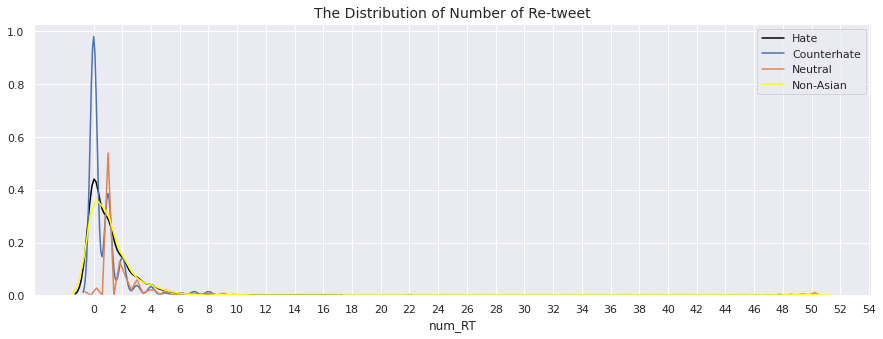

In [158]:
sns.set()
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.distplot(h_df['num_RT'],hist=False,ax=ax,label="Hate",color='black')
sns.distplot(c_df['num_RT'],hist=False,ax=ax,label="Counterhate")
sns.distplot(n_df['num_RT'],hist=False,ax=ax,label="Neutral")
sns.distplot(na_df['num_RT'],hist=False,ax=ax,label="Non-Asian",color="yellow")
plt.grid(True)
plt.title("The Distribution of Number of Re-tweet", fontsize=14)
plt.xticks(range(0,55,2))
plt.show()

From this graph, we could see people sending counterhate tweet were not likely to send re-tweet. To some extent, neutral tweets would be likely to be sent based on other's tweet.

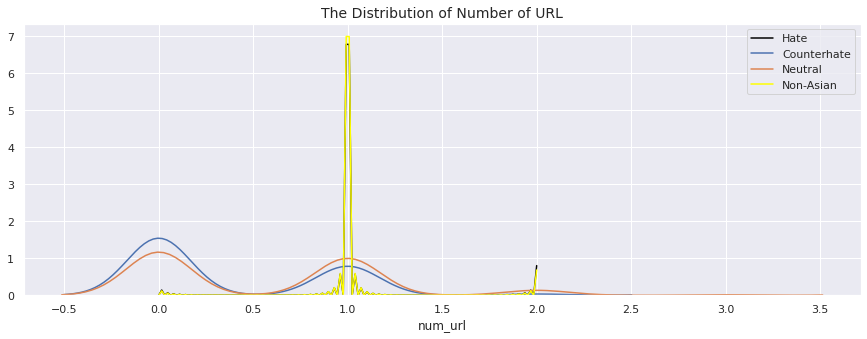

In [157]:
sns.set()
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.distplot(h_df['num_url'],hist=False,ax=ax,label="Hate",color='black')
sns.distplot(c_df['num_url'],hist=False,ax=ax,label="Counterhate")
sns.distplot(n_df['num_url'],hist=False,ax=ax,label="Neutral")
sns.distplot(na_df['num_url'],hist=False,ax=ax,label="Non-Asian",color="yellow")
plt.grid(True)
plt.title("The Distribution of Number of URL", fontsize=14)
plt.show()

The Non-asian tweets are likely to contain URLs.

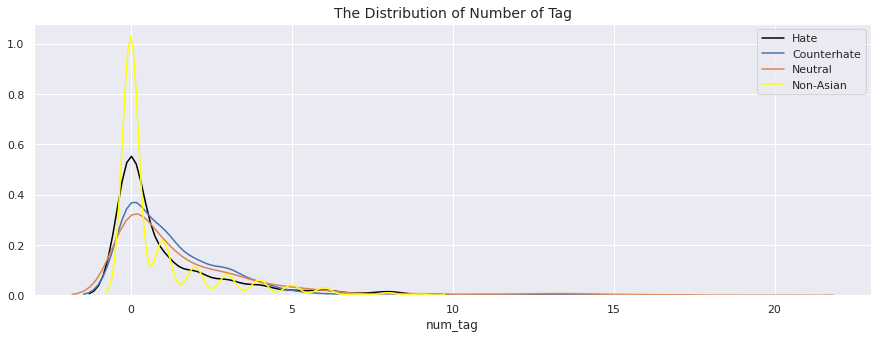

In [161]:
sns.set()
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.distplot(h_df['num_tag'],hist=False,ax=ax,label="Hate",color='black')
sns.distplot(c_df['num_tag'],hist=False,ax=ax,label="Counterhate")
sns.distplot(n_df['num_tag'],hist=False,ax=ax,label="Neutral")
sns.distplot(na_df['num_tag'],hist=False,ax=ax,label="Non-Asian",color="yellow")
plt.grid(True)
plt.title("The Distribution of Number of Tag", fontsize=14)
plt.show()

People tend to miss tags when sending non-asian tweets.

### Common Words and Word Could

In [208]:
def get_most_common(series,n):
  _text = []
  for i in series:
    _text += [j.text.lower() for j in nlp(i) if (j.text not in string.punctuation+ " ") and (not j.is_stop) and (j.text.lower() not in nltk.corpus.stopwords.words('english')) ]
  hate_freq = Counter(_text)
  return hate_freq.most_common(n=n)

def plot_word_cloud(series,l):
  _text = []
  for i in series:
    _text += [j.text.lower() for j in nlp(i) if (j.text not in string.punctuation+ " ") and (not j.is_stop) and (j.text.lower() not in nltk.corpus.stopwords.words('english')) ]
  _text = " ".join(_text)
  w = WordCloud(background_color = "white", max_words = 200).generate(_text)

  plt.figure(figsize=(12,8))
  plt.imshow(w)
  plt.title(f"The most frequent words for {l}",fontsize=16)
  plt.grid(False)
  plt.show()

#### 1.Hate

In [211]:
get_most_common(h_df['Text'],20)

[('china', 355),
 ('chinese', 316),
 ('virus', 299),
 ('fuck', 173),
 ('coronavirus', 153),
 ('people', 146),
 ('shit', 130),
 ('world', 126),
 ('fucking', 109),
 ('ccp', 97),
 ("'s", 93),
 ('wuhan', 89),
 ('racist', 84),
 ('chinesevirus', 78),
 ('country', 74),
 ("n't", 59),
 ('...', 59),
 ('like', 56),
 ('amp', 55),
 ('’s', 53)]

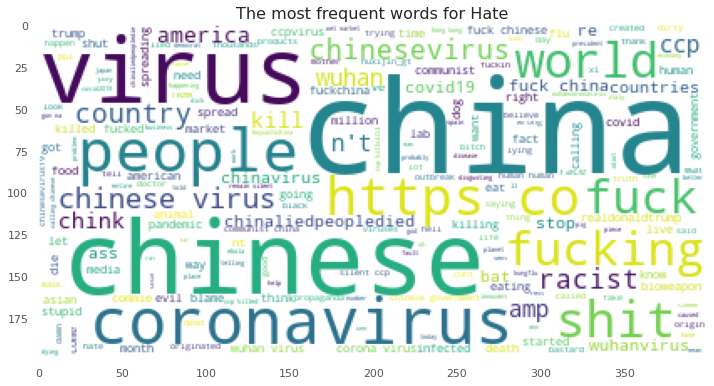

In [215]:
plot_word_cloud(h_df['Text'],'Hate')

There are a large amount of words refer to China, which exhibit the fact that "china" and "chinese" are the center of anti-asian hate speech due to coronavirus.

#### 2.Counter Hate

In [216]:
get_most_common(c_df['Text'],20)

[('chinese', 158),
 ('virus', 140),
 ('asian', 117),
 ('racist', 102),
 ('coronavirus', 86),
 ('people', 85),
 ('racismisavirus', 70),
 ("'s", 59),
 ('china', 57),
 ('iamnotavirus', 54),
 ('“', 53),
 ('’s', 52),
 ('”', 51),
 ('racism', 50),
 ('n’t', 41),
 ('asians', 40),
 ('covid19', 37),
 ('washthehate', 37),
 ('fucking', 35),
 ('calling', 34)]

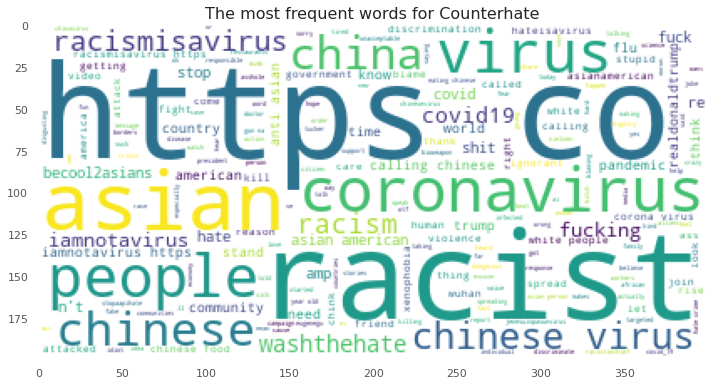

In [214]:
plot_word_cloud(c_df['Text'],'Counterhate')

From this graph, we could conclude that people holding counterhate idea are likely to be againest racist. However, we still could find "china" and "chinese" are two of most frequent words.

#### 3.Neutral

In [217]:
get_most_common(n_df['Text'],15)

[('coronavirus', 461),
 ('virus', 176),
 ('china', 162),
 ('chinese', 157),
 ('people', 131),
 ('asian', 127),
 ('covid19', 101),
 ('  ', 95),
 ('shit', 94),
 ("'s", 88),
 ('...', 87),
 ('racismisavirus', 81),
 ('racist', 78),
 ('’s', 77),
 ('like', 75)]

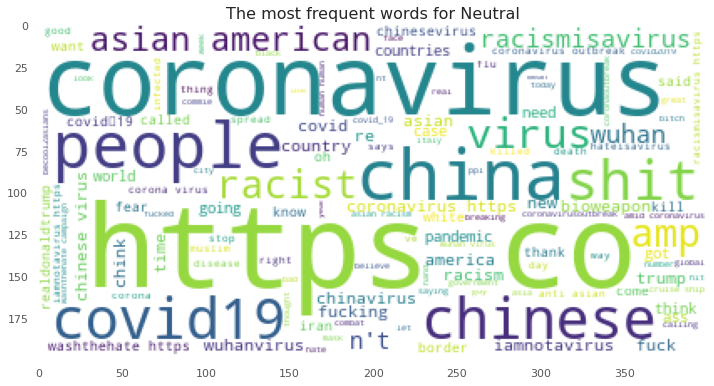

In [218]:
plot_word_cloud(n_df['Text'],"Neutral")

Even these neutral tweets, we still could find many similar words which appeared in "hate" and "counterhate"

#### 4.Non-Asian Hate

In [219]:
get_most_common(na_df['Text'],15)

[('virus', 119),
 ('coronavirus', 98),
 ('chinese', 95),
 ('china', 75),
 ('people', 55),
 ('ass', 52),
 ('shit', 51),
 ('racist', 46),
 ("n't", 44),
 ('like', 42),
 ('trump', 42),
 ("'s", 41),
 ('fucking', 40),
 ('amp', 40),
 ('wuhan', 38)]

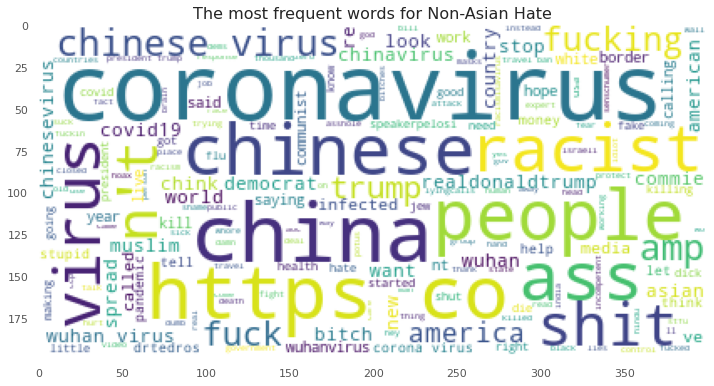

In [220]:
plot_word_cloud(na_df['Text'],'Non-Asian Hate')

Most words sill refer to "china" and "chinese" but we could see "trump" and "democrat" also appear in this label. That means people are likely to blame to president and democrat instead of "china" and "chinese"

## Training Feature Extractor (Embedding Attention + GRU)

In [19]:
class Attention(nn.Module):
  def __init__(self,batchsize,sentence_length,hidden_dim):
    super().__init__()
    self.Wk = nn.Linear(hidden_dim,hidden_dim) #nn.Parameter(data=torch.randn(batchsize,sentence_length,300))
    self.Wv = nn.Linear(hidden_dim,hidden_dim) #nn.Parameter(data=torch.randn(batchsize,sentence_length,300))
    self.Wq = nn.Linear(hidden_dim,hidden_dim) #nn.Parameter(data=torch.randn(batchsize,sentence_length,300))

  def forward(self,input_vec):
    """
    Input_vec: batch_size * seq_len * hidden_dim
    
    """
    bs,seq_len,hd = input_vec.shape
    inverse_vec = input_vec.permute(0,2,1) # [b,300,s]

    K = self.Wk(input_vec) # [batchsize,seq,hidden_dim]
    Q = self.Wq(input_vec) # [batchsize,1,hidden_dim]
    V = self.Wv(input_vec) # [batchsize,seq,hidden_dim]

    context_vec = torch.bmm(K,Q.permute(0,2,1)) # [weight, seq] 
    context_vec = context_vec.view(bs*seq_len,seq_len)
    attn_weights = torch.softmax(context_vec,dim=-1).view(bs,seq_len,seq_len)
    output_ = torch.bmm(V.permute(0,2,1),attn_weights)
    output_ = output_.permute(0,2,1)
    return output_


class FE_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding_layer = nn.Embedding(TOKENIZER.get_vocab_size(),300,padding_idx=0)
    self.attn = Attention(32,192,300)
    self.gru = nn.GRU(300,128,bidirectional=True,num_layers=4,dropout=0.5)
    self.fc0 = nn.Linear(128*2,300)
    self.dp = nn.Dropout(0.3)
    self.fc1 = nn.Linear(300,1)
    self.fc2 = nn.Linear(192,128)

  def forward(self,ids):
    x = self.embedding_layer(ids)
    attn_x = self.attn(x)
    output_x, hs = self.gru(x)

    output_x = self.fc0(output_x) + attn_x
    x = self.fc1(self.dp(output_x)).squeeze(2)
    x = self.fc2(x)
    return x

class Linear_Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(128,1)

  def forward(self,x,y):
    vec = torch.abs(x-y)
    vec = self.fc1(vec)
    return vec.squeeze(1)

In [20]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count



def train_fn(fe_model, cl_model,data_loader,criterion,opt):
  fe_model.train()
  cl_model.train()

  losses = AverageMeter()
  accuracy = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  for data_ in tk0:
    ids = data_['ids'].to(device)
    pair_ids = data_['pair_ids'].to(device)
    labels = data_['labels'].float().to(device)

    opt.zero_grad()

    latent_vec = fe_model(ids)
    latent_vec1 = fe_model(pair_ids)



    #vec = torch.cat([latent_vec,latent_vec1],dim=1)
    logits = cl_model(latent_vec,latent_vec1)

    loss = criterion(logits,labels)

    loss.backward()
    opt.step()

    y_p = torch.sigmoid(logits).ge(0.5).float().detach().cpu().numpy()
    y_t = labels.detach().cpu().numpy()
    acc = accuracy_score(y_pred=y_p, y_true=y_t)


    losses.update(loss.item(), ids.size(0))
    accuracy.update(acc,ids.size(0))

    tk0.set_postfix(loss = losses.avg, accuracy = accuracy.avg)

  return losses.avg, accuracy.avg

def eval_fn(fe_model, cl_model, data_loader,criterion):
  fe_model.eval()
  cl_model.eval()

  losses = AverageMeter()
  accuracy = AverageMeter()
  tk0 = tqdm(data_loader, total=len(data_loader))
  for data_ in tk0:
    ids = data_['ids'].to(device)
    pair_ids = data_['pair_ids'].to(device)
    labels = data_['labels'].float().to(device)


    latent_vec = fe_model(ids)
    latent_vec1 = fe_model(pair_ids)

    #vec = torch.cat([latent_vec,latent_vec1],dim=1)
    logits = cl_model(latent_vec,latent_vec1)

    loss = criterion(logits,labels)

    y_p = torch.sigmoid(logits).ge(0.5).float().detach().cpu().numpy()
    y_t = labels.detach().cpu().numpy()
    acc = accuracy_score(y_pred=y_p, y_true=y_t)

    losses.update(loss.item(), ids.size(0))
    accuracy.update(acc,ids.size(0))

    tk0.set_postfix(loss = losses.avg, accuracy = accuracy.avg)

  return losses.avg, accuracy.avg

In [ ]:
fe_model = FE_model().to(device)
cl_model = Linear_Classifier().to(device)

criterion = nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW( list(fe_model.parameters())+ list(cl_model.parameters()), lr=3e-4)
schduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode="max",patience=1,verbose=True)

EPOCHS = 5
tr_loader, val_loader = create_dataloader(tr_data),create_dataloader(val_data)
best_acc = 0
for e in range(1,EPOCHS+1):
  tr_loss, tr_acc = train_fn(fe_model,cl_model,tr_loader,criterion,opt)
  val_loss, val_acc = eval_fn(fe_model,cl_model,val_loader,criterion)

  print(f"Epoch: {e} | Training Loss: {tr_loss} | Training Accuracy: {tr_acc}")
  print(f"\t\t Validation Loss: {val_loss} | Validation Accuracy: {val_acc}")
  if val_acc>best_acc:
    best_acc = val_acc
    torch.save(fe_model.state_dict(),r"/content/drive/My Drive/Models/Feature_Extract/fe_model1.bin")


Epoch: 1 | Training Loss: 0.125082795033502 | Training Accuracy: 0.9481935960180521
		 Validation Loss: 0.017421736637655994 | Validation Accuracy: 0.9935136652028769



Epoch: 2 | Training Loss: 0.01633603186155573 | Training Accuracy: 0.9940556567713357
		 Validation Loss: 0.01864142739395741 | Validation Accuracy: 0.9938401352558484



Epoch: 3 | Training Loss: 0.0126300758887695 | Training Accuracy: 0.9950422129341859
		 Validation Loss: 0.014962234511398371 | Validation Accuracy: 0.994738969827221



Epoch: 4 | Training Loss: 0.011537291099996183 | Training Accuracy: 0.9952756046154396
		 Validation Loss: 0.011490059415514148 | Validation Accuracy: 0.9952238125867403



Epoch: 5 | Training Loss: 0.011227317775583102 | Training Accuracy: 0.9952732230676716
		 Validation Loss: 0.01308818053426115 | Validation Accuracy: 0.9950001458695982


## 4-way 10-shot Prediction

In [43]:
fe_model = FE_model().to(device)
fe_model.load_state_dict(torch.load(r"/content/drive/My Drive/Models/Feature_Extract/fe_model1.bin") )
fe_model.eval()

FE_model(
  (embedding_layer): Embedding(50265, 300, padding_idx=0)
  (attn): Attention(
    (Wk): Linear(in_features=300, out_features=300, bias=True)
    (Wv): Linear(in_features=300, out_features=300, bias=True)
    (Wq): Linear(in_features=300, out_features=300, bias=True)
  )
  (gru): GRU(300, 128, num_layers=4, dropout=0.5, bidirectional=True)
  (fc0): Linear(in_features=256, out_features=300, bias=True)
  (dp): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=300, out_features=1, bias=True)
  (fc2): Linear(in_features=192, out_features=128, bias=True)
)

In [37]:
class FewShot_Dataset:
  def __init__(self,df):
    self.text = df['Text']
    
    self.label = df['Label']
    self.encode_label = df['Encode_Label']

    self.tokenizer = TOKENIZER
    self.max_len = 192

  def __getitem__(self,idx):
    text = self.text.iloc[idx]
    encode_label = self.encode_label.iloc[idx]
    label = self.label.iloc[idx]

    text = self.process_tweet(text)
    

    ids = self.tokenizer.encode(text).ids
    padding_len = self.max_len - len(ids)
    if padding_len>0:
      ids += [0] * padding_len

    


    return {
        "ids":torch.tensor(ids),
        "labels":label,
        "encode_labels":torch.tensor(encode_label),
        "text":text
    }

  def __len__(self):
    return len(self.text)

  def remove_leading_usernames(self, tweet):
    """
        Remove all user handles at the beginning of the tweet.

        Parameters
        -----------------
        tweet : str, a valid string representation of the tweet text
    """
    regex_str = '^[\s.]*@[A-Za-z0-9_]+\s+'

    original = tweet
    change = re.sub(regex_str, '', original)

    while original != change:
      original = change
      change = re.sub(regex_str, '', original)

    return change
  def process_tweet(self, tweet):
    """
        Preprocess tweet. Remove URLs, leading user handles, retweet indicators, emojis,
        and unnecessary white space, and remove the pound sign from hashtags. Return preprocessed
        tweet in lowercase.

        Parameters
        -----------------
        tweet : str, a valid string representation of the tweet text
    """
    #Remove @username
    tweet = self.remove_leading_usernames(tweet)
    #Remove www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))\s+','',tweet)
    tweet = re.sub('\s+((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    #Remove RTs
    tweet = re.sub('^RT @[A-Za-z0-9_]+: ', '', tweet)
    tweet = re.sub(r'(@[a-z0-9A-Z]+)\w+','',tweet.lower())
    # Incorrect apostraphe
    tweet = re.sub(r"’", "'", tweet)
    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    #tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Replace ampersands
    tweet = re.sub(r' &amp; ', ' and ', tweet)
    tweet = re.sub(r'&amp;', '&', tweet)
    #Remove emojis
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    #trim
    tweet = tweet.strip('\'"')

    return tweet.lower().strip()


def create_dataloader(df,training=True,bs=32):
  return torch.utils.data.DataLoader(FewShot_Dataset(df),batch_size=bs,shuffle=training)

In [38]:
hate_loader = create_dataloader(hate_support_set,training=False)
counterhate_loader = create_dataloader(counterhate_support_set,training=False)
neutral_loader = create_dataloader(neutral_support_set,training=False)
other_loader = create_dataloader(other_support_set,training=False)


def support_fn(model,dl):
  model.eval()

  latent_vectors = []
  Labels = []
  for i in dl:
    ids = i['ids'].to(device)
    labels = np.array(i['labels'])

    latent_vec = model(ids)

    latent_vectors.append(latent_vec)
    Labels.append(labels)
  latent_vectors = torch.cat(latent_vectors)
  latent_vectors = latent_vectors/latent_vectors.norm(dim=1).view(-1,1)
  Labels = np.hstack(Labels)
  return latent_vectors,Labels

hate_vectors, hate_labels = support_fn(fe_model,hate_loader)
counterhate_vectors, counterhate_labels = support_fn(fe_model,counterhate_loader)
neutral_vectors, neutral_labels = support_fn(fe_model,neutral_loader)
other_vectors, other_labels = support_fn(fe_model,other_loader)

In [39]:
init_weight_mat = torch.cat([hate_vectors.mean(dim=0).unsqueeze(0),
counterhate_vectors.mean(dim=0).unsqueeze(0),
neutral_vectors.mean(dim=0).unsqueeze(0),
other_vectors.mean(dim=0).unsqueeze(0)],dim=0).detach()

class Cosine_classifier(nn.Module):
  def __init__(self, init_weight_mat = None):
    super().__init__()
    
    self.W = nn.Parameter(data=init_weight_mat if init_weight_mat!=None else torch.randn(4,128))

    self.fc0 = nn.Linear(128,128)
    
    self.act = nn.ReLU()
    self.dp = nn.Dropout()
    
    

  def forward(self,x):
    x = x/x.norm(dim=1).view(-1,1)
    cosine_simi = x.mm(self.W.T) / x.norm(dim=1).view(-1,1).mm(self.W.norm(dim=1).view(-1,1).T)
    return cosine_simi 

class Absoluate_classifier(nn.Module):
  def __init__(self, init_weight_mat = None):
    super().__init__()
    
    self.W = nn.Parameter(data=init_weight_mat if init_weight_mat!=None else torch.randn(4,128))

    self.fc0 = nn.Linear(128,128)
    nn.init.xavier_uniform_(self.fc0.weight)
    self.act = nn.ReLU()
    self.dp = nn.Dropout()

    self.abs_dist = nn.PairwiseDistance(p=1)
    
    

  def forward(self,x):
    x = x/x.norm(dim=1).view(-1,1)
    abs_distance = []
    for i in self.W:
      i = i.view(1,-1)
      abs_dist = self.abs_dist(x,i).view(-1,1)*-1
      abs_distance.append(abs_dist)
    abs_simi = torch.cat(abs_distance,dim=1) 

    return abs_simi

class Euclidean_classifier(nn.Module):
  def __init__(self, init_weight_mat = None):
    super().__init__()
    
    self.W = nn.Parameter(data=init_weight_mat if init_weight_mat!=None else torch.randn(4,128))

    self.fc0 = nn.Linear(128,128)
    
    self.act = nn.ReLU()
    self.dp = nn.Dropout()

    self.eu_dist = nn.PairwiseDistance(p=2)

  def forward(self,x):
    x = x/x.norm(dim=1).view(-1,1)
    eu_distance = []
    for i in self.W:
      i = i.view(1,-1)
      eu_dist = self.eu_dist(x,i).view(-1,1)*-1
      eu_distance.append(eu_dist)
    eu_simi = torch.cat(eu_distance,dim=1) 

    return eu_simi 

### Cosine Similarity

In [40]:
cos_model = Cosine_classifier(init_weight_mat).to(device)
opt1 = torch.optim.Adam( cos_model.parameters(),lr=3e-5)
criterion1 = nn.CrossEntropyLoss()
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt1,mode='max',patience=1,verbose=True)

In [41]:
train_loader = create_dataloader(train_data,training=True)
test_loader = create_dataloader(test_data,training=False)

class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def fs_train(feat_model,cl_model,data_loader,criterion,opt):
  feat_model.eval()
  cl_model.train()

  losses = AverageMeter()
  accuracy = AverageMeter()

  tk0 = tqdm(data_loader, total=len(data_loader))
  for data_ in tk0:
    ids = data_['ids'].to(device)
    labels = data_['labels']
    encode_labels = data_['encode_labels'].to(device)

    opt.zero_grad()

    latent_vec = feat_model(ids)
    latent_vec = latent_vec.detach()
    logits = cl_model(latent_vec)

    loss = criterion(logits,encode_labels)

    acc = accuracy_score(encode_labels.detach().cpu().numpy(),logits.argmax(dim=1).detach().cpu().numpy() )

    loss.backward()
    opt.step()

    losses.update(loss.item(), ids.size(0))
    accuracy.update(acc, ids.size(0))
    tk0.set_postfix(loss = losses.avg, accuracy = accuracy.avg)
  return losses.avg,accuracy.avg


def fs_test(feat_model, cl_model,data_loader,criterion):
  cl_model.eval()
  feat_model.eval()

  losses = AverageMeter()
  accuracy = AverageMeter()

  tk0 = tqdm(data_loader, total=len(data_loader))
  
  ts_targets = []
  ts_preds = []

  for data_ in tk0:
    ids = data_['ids'].to(device)
    labels = data_['labels']
    encode_labels = data_['encode_labels'].to(device)

    latent_vec = feat_model(ids)
    logits = cl_model(latent_vec)

    loss = criterion(logits,encode_labels)
    preds = logits.argmax(dim=1).detach().cpu().numpy().tolist()
    acc = accuracy_score(encode_labels.detach().cpu().numpy(),logits.argmax(dim=1).detach().cpu().numpy() )

    losses.update(loss.item(), ids.size(0))
    accuracy.update(acc, ids.size(0))

    tk0.set_postfix(loss = losses.avg, accuracy = accuracy.avg)
    ts_preds += preds
    ts_targets += encode_labels.detach().cpu().tolist()
  
  print(classification_report(ts_targets,ts_preds,target_names=['Hate',"Counterhate","Neutral","Others"]))
  return losses.avg,accuracy.avg

In [42]:
for e in range(20):
  tr_fs_loss,tr_fs_acc = fs_train(fe_model,cos_model,train_loader,criterion1,opt1)
  ts_fs_loss,ts_fs_acc = fs_test(fe_model,cos_model,test_loader,criterion1)
  scheduler1.step(ts_fs_acc)



              precision    recall  f1-score   support

        Hate       0.87      0.87      0.87       198
 Counterhate       0.38      0.89      0.54       105
     Neutral       0.85      0.34      0.48       269
      Others       0.59      0.74      0.65        92

    accuracy                           0.64       664
   macro avg       0.67      0.71      0.64       664
weighted avg       0.75      0.64      0.63       664




              precision    recall  f1-score   support

        Hate       0.87      0.87      0.87       198
 Counterhate       0.40      0.89      0.55       105
     Neutral       0.85      0.37      0.51       269
      Others       0.60      0.74      0.66        92

    accuracy                           0.65       664
   macro avg       0.68      0.72      0.65       664
weighted avg       0.75      0.65      0.65       664




              precision    recall  f1-score   support

        Hate       0.87      0.87      0.87       198
 Counterhate       0.41      0.87      0.56       105
     Neutral       0.84      0.41      0.55       269
      Others       0.59      0.73      0.65        92

    accuracy                           0.66       664
   macro avg       0.68      0.72      0.66       664
weighted avg       0.75      0.66      0.66       664




              precision    recall  f1-score   support

        Hate       0.87      0.87      0.87       198
 Counterhate       0.44      0.87      0.58       105
     Neutral       0.84      0.45      0.58       269
      Others       0.60      0.74      0.66        92

    accuracy                           0.68       664
   macro avg       0.69      0.73      0.67       664
weighted avg       0.75      0.68      0.68       664




              precision    recall  f1-score   support

        Hate       0.87      0.87      0.87       198
 Counterhate       0.45      0.86      0.59       105
     Neutral       0.84      0.47      0.60       269
      Others       0.61      0.74      0.67        92

    accuracy                           0.69       664
   macro avg       0.69      0.74      0.68       664
weighted avg       0.75      0.69      0.69       664




              precision    recall  f1-score   support

        Hate       0.88      0.87      0.88       198
 Counterhate       0.45      0.86      0.59       105
     Neutral       0.84      0.49      0.62       269
      Others       0.60      0.75      0.67        92

    accuracy                           0.70       664
   macro avg       0.69      0.74      0.69       664
weighted avg       0.76      0.70      0.70       664




              precision    recall  f1-score   support

        Hate       0.88      0.87      0.88       198
 Counterhate       0.48      0.86      0.61       105
     Neutral       0.84      0.52      0.64       269
      Others       0.61      0.75      0.67        92

    accuracy                           0.71       664
   macro avg       0.70      0.75      0.70       664
weighted avg       0.76      0.71      0.71       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.49      0.85      0.62       105
     Neutral       0.83      0.54      0.66       269
      Others       0.60      0.76      0.67        92

    accuracy                           0.72       664
   macro avg       0.70      0.75      0.71       664
weighted avg       0.76      0.72      0.72       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.53      0.84      0.65       105
     Neutral       0.84      0.59      0.69       269
      Others       0.60      0.76      0.67        92

    accuracy                           0.73       664
   macro avg       0.71      0.76      0.72       664
weighted avg       0.77      0.73      0.73       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.56      0.84      0.67       105
     Neutral       0.83      0.61      0.71       269
      Others       0.60      0.76      0.67        92

    accuracy                           0.74       664
   macro avg       0.72      0.77      0.73       664
weighted avg       0.77      0.74      0.75       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.58      0.83      0.68       105
     Neutral       0.84      0.64      0.73       269
      Others       0.60      0.76      0.67        92

    accuracy                           0.75       664
   macro avg       0.73      0.77      0.74       664
weighted avg       0.78      0.75      0.76       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.60      0.83      0.70       105
     Neutral       0.84      0.67      0.75       269
      Others       0.61      0.76      0.68        92

    accuracy                           0.76       664
   macro avg       0.74      0.78      0.75       664
weighted avg       0.79      0.76      0.77       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.64      0.81      0.72       105
     Neutral       0.84      0.71      0.77       269
      Others       0.61      0.76      0.68        92

    accuracy                           0.78       664
   macro avg       0.75      0.78      0.76       664
weighted avg       0.79      0.78      0.78       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.67      0.79      0.72       105
     Neutral       0.83      0.73      0.78       269
      Others       0.61      0.75      0.67        92

    accuracy                           0.78       664
   macro avg       0.75      0.78      0.76       664
weighted avg       0.79      0.78      0.78       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.73      0.78      0.75       105
     Neutral       0.83      0.76      0.79       269
      Others       0.61      0.75      0.67        92

    accuracy                           0.79       664
   macro avg       0.76      0.79      0.77       664
weighted avg       0.80      0.79      0.79       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.74      0.78      0.76       105
     Neutral       0.83      0.78      0.80       269
      Others       0.61      0.76      0.68        92

    accuracy                           0.80       664
   macro avg       0.77      0.79      0.78       664
weighted avg       0.81      0.80      0.80       664




              precision    recall  f1-score   support

        Hate       0.90      0.85      0.88       198
 Counterhate       0.77      0.74      0.76       105
     Neutral       0.82      0.80      0.81       269
      Others       0.61      0.76      0.68        92

    accuracy                           0.80       664
   macro avg       0.78      0.79      0.78       664
weighted avg       0.81      0.80      0.80       664




              precision    recall  f1-score   support

        Hate       0.90      0.85      0.88       198
 Counterhate       0.77      0.72      0.75       105
     Neutral       0.81      0.80      0.81       269
      Others       0.61      0.76      0.68        92

    accuracy                           0.80       664
   macro avg       0.77      0.78      0.78       664
weighted avg       0.81      0.80      0.80       664




              precision    recall  f1-score   support

        Hate       0.90      0.85      0.88       198
 Counterhate       0.80      0.70      0.75       105
     Neutral       0.81      0.81      0.81       269
      Others       0.61      0.76      0.68        92

    accuracy                           0.80       664
   macro avg       0.78      0.78      0.78       664
weighted avg       0.81      0.80      0.80       664

Epoch    19: reducing learning rate of group 0 to 3.0000e-06.



              precision    recall  f1-score   support

        Hate       0.90      0.85      0.88       198
 Counterhate       0.80      0.70      0.75       105
     Neutral       0.81      0.82      0.81       269
      Others       0.61      0.76      0.68        92

    accuracy                           0.80       664
   macro avg       0.78      0.78      0.78       664
weighted avg       0.81      0.80      0.80       664



### Absoluate Distance

In [45]:
ab_model = Absoluate_classifier(init_weight_mat).to(device)
opt2 = torch.optim.Adam( ab_model.parameters(),lr=3e-5)
criterion2 = nn.CrossEntropyLoss()
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt2,mode='max',patience=1,verbose=True)

In [46]:
for e in range(20):
  tr_fs_loss,tr_fs_acc = fs_train(fe_model,ab_model,train_loader,criterion2,opt2)
  ts_fs_loss,ts_fs_acc = fs_test(fe_model,ab_model,test_loader,criterion2)
  scheduler2.step(ts_fs_acc)



              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.81      0.70      0.76       105
     Neutral       0.82      0.81      0.82       269
      Others       0.63      0.78      0.70        92

    accuracy                           0.81       664
   macro avg       0.79      0.79      0.79       664
weighted avg       0.81      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.82      0.70      0.76       105
     Neutral       0.82      0.82      0.82       269
      Others       0.63      0.78      0.70        92

    accuracy                           0.81       664
   macro avg       0.79      0.79      0.79       664
weighted avg       0.81      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.83      0.70      0.76       105
     Neutral       0.82      0.83      0.82       269
      Others       0.63      0.78      0.70        92

    accuracy                           0.81       664
   macro avg       0.79      0.79      0.79       664
weighted avg       0.82      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.83      0.70      0.76       105
     Neutral       0.82      0.83      0.82       269
      Others       0.64      0.78      0.70        92

    accuracy                           0.81       664
   macro avg       0.79      0.79      0.79       664
weighted avg       0.82      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.84      0.70      0.76       105
     Neutral       0.82      0.83      0.83       269
      Others       0.64      0.78      0.71        92

    accuracy                           0.81       664
   macro avg       0.80      0.79      0.79       664
weighted avg       0.82      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.84      0.70      0.76       105
     Neutral       0.82      0.84      0.83       269
      Others       0.65      0.77      0.70        92

    accuracy                           0.81       664
   macro avg       0.80      0.79      0.79       664
weighted avg       0.82      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.86      0.70      0.77       105
     Neutral       0.81      0.85      0.83       269
      Others       0.66      0.76      0.71        92

    accuracy                           0.82       664
   macro avg       0.81      0.79      0.80       664
weighted avg       0.82      0.82      0.82       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.86      0.70      0.77       105
     Neutral       0.81      0.85      0.83       269
      Others       0.66      0.75      0.70        92

    accuracy                           0.82       664
   macro avg       0.81      0.79      0.80       664
weighted avg       0.82      0.82      0.82       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.88      0.70      0.78       105
     Neutral       0.80      0.86      0.83       269
      Others       0.67      0.75      0.71        92

    accuracy                           0.82       664
   macro avg       0.81      0.79      0.80       664
weighted avg       0.82      0.82      0.82       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.88      0.71      0.79       105
     Neutral       0.81      0.86      0.83       269
      Others       0.67      0.75      0.71        92

    accuracy                           0.82       664
   macro avg       0.81      0.80      0.80       664
weighted avg       0.83      0.82      0.82       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.88      0.71      0.79       105
     Neutral       0.80      0.86      0.83       269
      Others       0.68      0.75      0.72        92

    accuracy                           0.82       664
   macro avg       0.82      0.80      0.80       664
weighted avg       0.83      0.82      0.82       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.88      0.71      0.79       105
     Neutral       0.80      0.86      0.83       269
      Others       0.68      0.75      0.72        92

    accuracy                           0.82       664
   macro avg       0.82      0.80      0.80       664
weighted avg       0.83      0.82      0.82       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.90      0.71      0.80       105
     Neutral       0.81      0.87      0.84       269
      Others       0.68      0.75      0.72        92

    accuracy                           0.83       664
   macro avg       0.82      0.80      0.81       664
weighted avg       0.83      0.83      0.83       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.90      0.71      0.80       105
     Neutral       0.81      0.87      0.84       269
      Others       0.68      0.75      0.72        92

    accuracy                           0.83       664
   macro avg       0.82      0.80      0.81       664
weighted avg       0.83      0.83      0.83       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.92      0.72      0.81       105
     Neutral       0.81      0.87      0.84       269
      Others       0.68      0.74      0.71        92

    accuracy                           0.83       664
   macro avg       0.82      0.80      0.81       664
weighted avg       0.83      0.83      0.83       664




              precision    recall  f1-score   support

        Hate       0.90      0.86      0.88       198
 Counterhate       0.91      0.71      0.80       105
     Neutral       0.80      0.87      0.84       269
      Others       0.68      0.74      0.71        92

    accuracy                           0.83       664
   macro avg       0.82      0.80      0.81       664
weighted avg       0.83      0.83      0.83       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.93      0.71      0.81       105
     Neutral       0.80      0.87      0.84       269
      Others       0.68      0.73      0.70        92

    accuracy                           0.83       664
   macro avg       0.82      0.79      0.81       664
weighted avg       0.83      0.83      0.83       664

Epoch    17: reducing learning rate of group 0 to 3.0000e-06.



              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.93      0.71      0.81       105
     Neutral       0.80      0.87      0.84       269
      Others       0.68      0.73      0.70        92

    accuracy                           0.83       664
   macro avg       0.82      0.79      0.81       664
weighted avg       0.83      0.83      0.83       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.93      0.71      0.81       105
     Neutral       0.80      0.87      0.84       269
      Others       0.68      0.73      0.70        92

    accuracy                           0.83       664
   macro avg       0.82      0.79      0.81       664
weighted avg       0.83      0.83      0.83       664

Epoch    19: reducing learning rate of group 0 to 3.0000e-07.



              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.93      0.71      0.81       105
     Neutral       0.80      0.87      0.84       269
      Others       0.68      0.73      0.70        92

    accuracy                           0.83       664
   macro avg       0.82      0.79      0.81       664
weighted avg       0.83      0.83      0.83       664



### Euclidean Distance

In [49]:
eu_model = Euclidean_classifier(init_weight_mat).to(device)
opt2 = torch.optim.Adam( eu_model.parameters(),lr=3e-5)
criterion2 = nn.CrossEntropyLoss()
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt2,mode='max',patience=1,verbose=True)

In [50]:
for e in range(20):
  tr_fs_loss,tr_fs_acc = fs_train(fe_model,eu_model,train_loader,criterion2,opt2)
  ts_fs_loss,ts_fs_acc = fs_test(fe_model,eu_model,test_loader,criterion2)
  scheduler2.step(ts_fs_acc)



              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.97      0.60      0.74       105
     Neutral       0.77      0.90      0.83       269
      Others       0.71      0.73      0.72        92

    accuracy                           0.81       664
   macro avg       0.83      0.77      0.79       664
weighted avg       0.83      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.88       198
 Counterhate       0.97      0.58      0.73       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.72      0.71        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.83      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.71      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.83      0.81      0.81       664

Epoch     3: reducing learning rate of group 0 to 3.0000e-06.



              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.71      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.83      0.81      0.81       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664

Epoch     5: reducing learning rate of group 0 to 3.0000e-07.



              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664

Epoch     7: reducing learning rate of group 0 to 3.0000e-08.



              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664

Epoch     9: reducing learning rate of group 0 to 3.0000e-09.



              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664




              precision    recall  f1-score   support

        Hate       0.89      0.86      0.87       198
 Counterhate       0.98      0.57      0.72       105
     Neutral       0.76      0.90      0.82       269
      Others       0.70      0.70      0.70        92

    accuracy                           0.81       664
   macro avg       0.83      0.76      0.78       664
weighted avg       0.82      0.81      0.80       664



## Experiment Results

In [229]:
hate_results = pd.DataFrame(columns=["Cosine","Absoluate","Euclidean"],index=['Precision',"Recall","F1-Score","Accuracy"])
hate_results['Cosine'] = [0.90,0.85,0.88,0.80]
hate_results['Absoluate'] =  [0.89,0.86,0.88,0.83 ]
hate_results['Euclidean'] =  [0.89,0.86,0.87,0.81]

hate_results

,Cosine,Absoluate,Euclidean
Precision,0.90,0.89,0.89
Recall,0.85,0.86,0.86
F1-Score,0.88,0.88,0.87
Accuracy,0.80,0.83,0.81


In [231]:
counterhate_results = pd.DataFrame(columns=["Cosine","Absoluate","Euclidean"],index=['Precision',"Recall","F1-Score","Accuracy"])
counterhate_results['Cosine'] = [0.80,0.7,0.75,0.80]
counterhate_results['Absoluate'] = [0.93,0.71,0.81,0.83 ]
counterhate_results['Euclidean'] = [0.98,0.57,0.72,0.81]

counterhate_results

,Cosine,Absoluate,Euclidean
Precision,0.80,0.93,0.98
Recall,0.70,0.71,0.57
F1-Score,0.75,0.81,0.72
Accuracy,0.80,0.83,0.81


In [234]:
neutral_results = pd.DataFrame(columns=["Cosine","Absoluate","Euclidean"],index=['Precision',"Recall","F1-Score","Accuracy"])
neutral_results['Cosine'] =  [0.81, 0.82,0.81,0.80]
neutral_results['Absoluate'] = [0.80, 0.87,0.84,0.83 ]
neutral_results['Euclidean'] = [0.76, 0.90,0.82 ,0.81]
neutral_results

,Cosine,Absoluate,Euclidean
Precision,0.81,0.80,0.76
Recall,0.82,0.87,0.90
F1-Score,0.81,0.84,0.82
Accuracy,0.80,0.83,0.81


In [235]:
non_asian_results = pd.DataFrame(columns=["Cosine","Absoluate","Euclidean"],index=['Precision',"Recall","F1-Score","Accuracy"])
non_asian_results['Cosine'] =  [0.61,0.76,0.68,0.80]
non_asian_results['Absoluate'] = [0.68,0.73,0.70,0.83 ]
non_asian_results['Euclidean'] = [0.70,0.70,0.70 ,0.81]
non_asian_results

,Cosine,Absoluate,Euclidean
Precision,0.61,0.68,0.70
Recall,0.76,0.73,0.70
F1-Score,0.68,0.70,0.70
Accuracy,0.80,0.83,0.81


## Summary

- **Conclusion**:
Few-shot learning is a cutting-edge method. It overcomes the problems that deep learning model can not fit the small dataset very well. In this way, we could apply complex deep learning models on tabular data regardless of data size. However, it is not perfect because we could not have good performance in "Non-Asian Hate" label. The reason is that "Non-Asian Hate" and "Hate" are highly correlated because of similar contents. It lays a new challenge for us.
- **Future Work**: I will make efforts to lighten inner correlation between four labels to improve model performance.